[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aanas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aanas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aanas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artist         2248 non-null   object
 1   title          2248 non-null   object
 2   mood           2248 non-null   int64 
 3   original_mood  2248 non-null   object
 4   lyrics         2215 non-null   object
dtypes: int64(1), object(4)
memory usage: 87.9+ KB
None
              mood
count  2248.000000
mean      1.578292
std       1.109537
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       3.000000
           artist               title  mood original_mood  \
0  George Michael     I Want Your Sex     1         happy   
1      Rob Zombie        Pussy Liquor     0         angry   
2     Bing Crosby  Swinging On A Star     1         happy   
3        Ludacris            Get Back     0         angry   
4            Hole              Violet     0         angry   


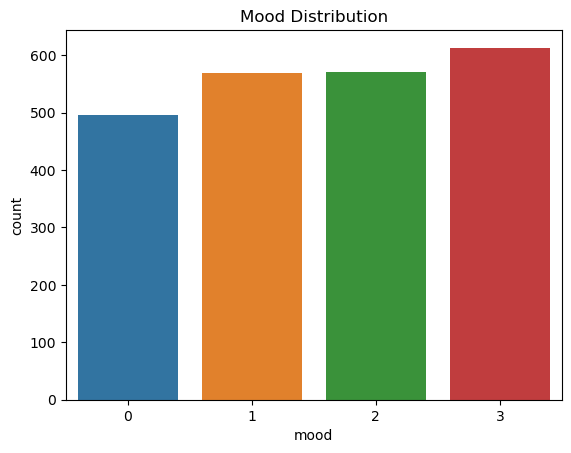

Removed 89 rows containing non-English lyrics.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

# Load the dataset
file_path = 'datasets/cleaned_dataset_with_lyrics.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
display(df.info())
display(df.describe())
display(df.head())

# Data Analysis: Visualize the distribution of the moods
sns.countplot(x='mood', data=df)
plt.title('Mood Distribution')
plt.show()

# Data Cleaning: Handle missing values
df.dropna(subset=['lyrics', 'mood'], inplace=True)                                     #####SHOULDN'T NEED THIS

# Data Cleaning: Feature Selection
df = df[['lyrics', 'mood']]

# Function to check if the lyrics are in English
def eng_ratio(text):
    ''' Returns the ratio of English to total words from a text '''
    english_vocab = set(w.lower() for w in words.words())
    text_vocab = set(w.lower() for w in text.split() if w.lower().isalpha())
    unusual = text_vocab.difference(english_vocab)
    eng_ratio = (len(text_vocab) - len(unusual)) / len(text_vocab)
    return eng_ratio

# Filter out non-English lyrics
initial_row_count = df.shape[0]
df['eng_ratio'] = df['lyrics'].apply(eng_ratio)
df = df[df['eng_ratio'] > 0.5]
rows_removed_count = initial_row_count - df.shape[0]
print(f"Removed {rows_removed_count} rows containing non-English lyrics.")

# Text Preprocessing function
def preprocess_lyrics(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

# Apply preprocessing to the lyrics
df['lyrics'] = df['lyrics'].apply(preprocess_lyrics)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['mood'], test_size=0.2, random_state=42)

# Save the processed data
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
np.save('X_train_tfidf.npy', X_train_tfidf.toarray())
np.save('X_test_tfidf.npy', X_test_tfidf.toarray())


In [11]:
# machine_learning_models.py

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load the processed data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
X_train_tfidf = np.load('X_train_tfidf.npy')
X_test_tfidf = np.load('X_test_tfidf.npy')

# Machine Learning Model: SVM
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_tfidf, y_train.values.ravel())
y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Prepare dataset for RoBERTa and BERT
class SongDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_length):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyric = str(self.lyrics[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            lyric,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_transformer_model(model_class, train_dataset, val_dataset, model_name_path):
    model = model_class.from_pretrained(model_name_path, num_labels=len(pd.concat([y_train, y_test])['mood'].unique()))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy='epoch'
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': (preds == p.label_ids).astype(np.float32).mean().item()
    }

# Tokenizer and datasets for RoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset_roberta = SongDataset(X_train['lyrics'].values.tolist(), y_train['mood'].values.tolist(), roberta_tokenizer, max_length=128)
val_dataset_roberta = SongDataset(X_test['lyrics'].values.tolist(), y_test['mood'].values.tolist(), roberta_tokenizer, max_length=128)

# Tokenizer and datasets for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset_bert = SongDataset(X_train['lyrics'].values.tolist(), y_train['mood'].values.tolist(), bert_tokenizer, max_length=128)
val_dataset_bert = SongDataset(X_test['lyrics'].values.tolist(), y_test['mood'].values.tolist(), bert_tokenizer, max_length=128)

# Train RoBERTa model
trainer_roberta = train_transformer_model(RobertaForSequenceClassification, train_dataset_roberta, val_dataset_roberta, 'roberta-base')
trainer_bert = train_transformer_model(BertForSequenceClassification, train_dataset_bert, val_dataset_bert, 'bert-base-uncased')

# Evaluate models
eval_results_roberta = trainer_roberta.evaluate()
eval_results_bert = trainer_bert.evaluate()

print("RoBERTa Evaluation Results:")
print(eval_results_roberta)

print("BERT Evaluation Results:")
print(eval_results_bert)

# Compare results
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"RoBERTa Accuracy: {eval_results_roberta['eval_accuracy']}")
print(f"BERT Accuracy: {eval_results_bert['eval_accuracy']}")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       103
           1       0.58      0.52      0.55       110
           2       0.45      0.34      0.39       107
           3       0.40      0.60      0.48       106

    accuracy                           0.50       426
   macro avg       0.52      0.50      0.50       426
weighted avg       0.52      0.50      0.50       426

SVM Accuracy: 0.5023474178403756


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aanas\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`